In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current 

In [2]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv"

--2023-09-03 08:26:50--  https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1626269 (1.6M) [text/plain]
Saving to: ‘blp23_sentiment_test_with_label.tsv’

blp23_sentiment_tes 100%[===================>]   1.55M  --.-KB/s    in 0.02s   

2023-09-03 08:26:50 (66.8 MB/s) - ‘blp23_sentiment_test_with_label.tsv’ saved [1626269/1626269]



In [3]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.8 MB/s eta 0:00:00


In [4]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import torch

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip"

--2023-09-03 08:27:58--  https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645403 (2.5M) [application/zip]
Saving to: ‘sentiment_analysis_data.zip’

sentiment_analysis_ 100%[===================>]   2.52M  --.-KB/s    in 0.03s   

2023-09-03 08:27:58 (87.8 MB/s) - ‘sentiment_analysis_data.zip’ saved [2645403/2645403]



In [6]:
!unzip -o /kaggle/working/sentiment_analysis_data.zip

Archive:  /kaggle/working/sentiment_analysis_data.zip
  inflating: blp23_sentiment_dev_test.tsv  
  inflating: blp23_sentiment_dev.tsv  
  inflating: blp23_sentiment_train.tsv  


In [7]:
train_file = '/kaggle/working/blp23_sentiment_train.tsv'
validation_file = '/kaggle/working/blp23_sentiment_dev.tsv'
test_file = '/kaggle/working/blp23_sentiment_dev_test.tsv'

In [8]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="./bertBaseMultilingualNew/",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    local_rank= 1,
    load_best_model_at_end=True,
    save_total_limit=2,
    save_strategy="no"
)

max_train_samples = None
max_eval_samples=None
max_predict_samples=None
max_seq_length = 512
batch_size = 16

In [9]:
transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f" distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")

In [10]:
model_name = 'sagorsarker/bangla-bert-base'

In [11]:
set_seed(training_args.seed)

In [12]:
punctuations = ["|","‘",">","<","*",   "।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

def remove_url(word):
    return word.split("http")[0].strip()

def extreme_process(word):
    word_list = [word]
    splitter_list = ["**","*", "…", "-"]

    for i in splitter_list:
        if i in word:
            temp_list = word.split(i)
            word_list = list(filter(lambda x:x.strip() != "", temp_list))
            return word_list
    return word_list


def process_word(word):
    word = word.strip()
    if len(word) == 0:
        return []
    elif len(word) == 1:
        if word not in punctuations:
            return [word]
        else:
            return []
    else:
        word = remove_url(word)

        if len(word) == 0:
            return []
        elif len(word) == 1:
            if word in punctuations:
                return []
            else:
                return [word]
        else:
            if word[0] in punctuations:
                word = word[1:]
            if word[-1] in punctuations:
                word = word[:-1]

            word = extreme_process(word)

            return word

In [13]:
l2id = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_df = pd.read_csv(train_file, sep='\t')
print(train_df.head())

               id                                               text     label
0           10856  এখানে আরো ভালো ভাবে দলীয় ও র এর অবস্থান পাকা হ...   Neutral
1   sentinob_1072                   চুয়াডাঙ্গা বাড়ি কে বলেছে আপনার   Neutral
2  sentinob_10530      ভাই সোনাই ঘোষ এর দই খেয়ে যাইতেন , খুব ই মজার   Positive
3            8001  সমার তালুকদার আপনার ছবিতে ফেসটা কেন জানি বন্য ...  Negative
4  sentinob_10144  ভাইয়া এই নুডলস টা কোথায় কিনতে পাওয়া যাবে প্লিজ...  Positive


In [14]:
for index, row in train_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    train_df.at[index, "text"] = " ".join(processed_word_list)

In [15]:
train_df['label'] = train_df['label'].map(l2id)
print(train_df.head())

               id                                               text  label
0           10856  এখানে আরো ভালো ভাবে দলীয় ও র এর অবস্থান পাকা হ...      1
1   sentinob_1072                   চুয়াডাঙ্গা বাড়ি কে বলেছে আপনার      1
2  sentinob_10530         ভাই সোনাই ঘোষ এর দই খেয়ে যাইতেন খুব ই মজার      2
3            8001  সমার তালুকদার আপনার ছবিতে ফেসটা কেন জানি বন্য ...      0
4  sentinob_10144  ভাইয়া এই নুডলস টা কোথায় কিনতে পাওয়া যাবে প্লিজ...      2


In [16]:
train_df = Dataset.from_pandas(train_df)
print(train_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 35266
})


In [17]:
validation_df = pd.read_csv(validation_file, sep='\t')
for index, row in validation_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    validation_df.at[index, "text"] = " ".join(processed_word_list)

In [18]:
validation_df.head()

,id,text,label
0,5300,নতুন মতলব আটছে মানে সৌদি আরব ধ্বংস করার পায়তার...,Negative
1,15392,বিদেশে পড়ালেখা করছে বাংলাদেশের প্রচুর ছেলেময়ের...,Positive
2,6904,মাননীয় আপনি নিজে না বলে সস্তায় কোনো মন্ত্রী কে...,Negative
3,30790,করোনার টিকা নিলেন বিএনপি চেয়ারপারসন বেগম খালে...,Positive
4,2770,একজন প্রধানমন্ত্রীর এমন বক্তব্য জাতির জন্য লজ্...,Negative


In [19]:
validation_df['label'] = validation_df['label'].map(l2id)
validation_df = Dataset.from_pandas(validation_df)
print(validation_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 3934
})


In [20]:
old_test_df = pd.read_csv(test_file, sep='\t')
print(old_test_df.head())
print(len(old_test_df))

      id                                               text
0  30670   * করোনায় আরো ১৮৭ জনের মৃত্যু; মোট প্রাণহানি ...
1   4125          চাপাবাজীর চাপে এবার ধামাচাপা পড়বে আসল ইসু
2  27077   কুয়েতে বাংলাদেশী ফল খেতে হামলে পড়ছেন প্রবাসীরা
3  17552  তিনি ছিলেন টেস্ট খেলা সবচেয়ে বেশি বয়সী জীবিত...
4   4137  চাল আর পাট গুলো উৎপাদন করতে যে কৃষকের বাঁশ ঢুক...
3426


In [21]:
test_df = pd.read_csv("/kaggle/working/blp23_sentiment_test_with_label.tsv", sep="\t")
print(test_df.head())
print(len(test_df))

      id                                               text     label
0   7135  মুখস্ত শিক্ষা দিয়ে কি করবে এই জাতি ? বাংলাদেশ...  Negative
1  28949  জর্ডানের সাবেক যুবরাজ প্রিন্স হামজার ভিডিও বার...  Negative
2  10210  আমার ছেলের দুর্ভাগ্য না সৌভাগ্য জানিনা জ্বর এর...   Neutral
3   9526  Pranoy Sen তখন পাকিস্তান ও আফগানিস্তান ভারতের ...   Neutral
4   2142                              আরো কত মিথ্যাচার করবে  Negative
6707


In [22]:
test_df['label'] = test_df['label'].map(l2id)
print(test_df)

         id                                               text  label
0      7135  মুখস্ত শিক্ষা দিয়ে কি করবে এই জাতি ? বাংলাদেশ...      0
1     28949  জর্ডানের সাবেক যুবরাজ প্রিন্স হামজার ভিডিও বার...      0
2     10210  আমার ছেলের দুর্ভাগ্য না সৌভাগ্য জানিনা জ্বর এর...      1
3      9526  Pranoy Sen তখন পাকিস্তান ও আফগানিস্তান ভারতের ...      1
4      2142                              আরো কত মিথ্যাচার করবে      0
...     ...                                                ...    ...
6702  20643        গাছ কেটে শতাধিক পাখি হত্যায় আদালতে অভিযোগ       0
6703  15823  স্কুলে যাবি না মানে তুই তো যাবি তোর বড়টা ও যাই...      2
6704  29080  সুনামগঞ্জে হিন্দু গ্রামে হামলা: রাতভর পুলিশের ...      0
6705   3582  কারণ বাঙালি পিন মারতে ভালোবাসে শুধু টাকায় না ...      0
6706  19544           আর্জেন্টিনাকে বড় ব্যবধানে হারাল ব্রাজিল      2

[6707 rows x 3 columns]


In [23]:
for index, row in test_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    test_df.at[index, "text"] = " ".join(processed_word_list)

In [24]:
test_df = Dataset.from_pandas(test_df)
print(test_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 6707
})


In [25]:
data_files = {"train": train_df, "validation": validation_df, "test": test_df}
for key in data_files.keys():
    logger.info(f"loading a local file for {key}")

In [26]:
raw_datasets = DatasetDict(
    {"train": train_df, "validation": validation_df, "test": test_df}
)

In [27]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 35266
    })
    validation: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 3934
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 6707
    })
})


In [28]:
label_list = raw_datasets["train"].unique("label")
print(label_list)

[1, 2, 0]


In [29]:
label_list.sort()  # sort the labels for determine
print(label_list)

[0, 1, 2]


In [30]:
num_labels = len(label_list)
print(num_labels)

3


In [31]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task=None,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

[INFO|configuration_utils.py:715] 2023-09-03 08:28:09,253 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:775] 2023-09-03 08:28:09,265 >> Model config BertConfig {
  "_name_or_path": "sagorsarker/bangla-bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transfo

In [32]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
    revision="main",
    use_auth_token=None,
)

[INFO|tokenization_auto.py:526] 2023-09-03 08:28:09,634 >> Could not locate the tokenizer configuration file, will try to use the model config instead.
[INFO|configuration_utils.py:715] 2023-09-03 08:28:09,734 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:775] 2023-09-03 08:28:09,737 >> Model config BertConfig {
  "_name_or_path": "sagorsarker/bangla-bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transform

[INFO|tokenization_utils_base.py:1852] 2023-09-03 08:28:10,600 >> loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/vocab.txt
[INFO|tokenization_utils_base.py:1852] 2023-09-03 08:28:10,601 >> loading file tokenizer.json from cache at None
[INFO|tokenization_utils_base.py:1852] 2023-09-03 08:28:10,602 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:1852] 2023-09-03 08:28:10,603 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:1852] 2023-09-03 08:28:10,604 >> loading file tokenizer_config.json from cache at None
[INFO|configuration_utils.py:715] 2023-09-03 08:28:10,606 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:775] 2023-09-03 08:28:10,

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_name),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    ignore_mismatched_sizes=False,
)

[INFO|modeling_utils.py:2779] 2023-09-03 08:28:13,102 >> loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/model.safetensors
[INFO|modeling_utils.py:3541] 2023-09-03 08:28:14,846 >> Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequen

In [34]:
non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
print(non_label_column_names)

['id', 'text']


In [35]:
sentence_key= non_label_column_names[1]
print(sentence_key)

text


In [36]:
padding = "max_length"
label_to_id = None

if (model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {sorted(label_name_to_id.keys())}, dataset labels: {sorted(label_list)}."
            "\nIgnoring the model labels as a result.",)


if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}


if 128 > tokenizer.model_max_length:
    logger.warning(
        f"The max_seq_length passed ({128}) is larger than the maximum length for the"
        f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}.")


max_seq_length = min(128, tokenizer.model_max_length)
print(max_seq_length)

128


In [37]:
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence_key],))
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result

In [38]:
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/36 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/7 [00:00<?, ?ba/s]

In [39]:
if "train" not in raw_datasets:
    raise ValueError("requires a train dataset")

In [40]:
train_dataset = raw_datasets["train"]
print(train_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 35266
})


In [41]:
if "validation" not in raw_datasets:
    raise ValueError("requires a validation dataset")

In [42]:
eval_dataset = raw_datasets["validation"]
print(eval_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3934
})


In [43]:
print(max_eval_samples)

None


In [44]:
if max_eval_samples is not None:
    max_eval_samples_n = min(len(eval_dataset), max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples_n))

In [45]:
if "test" not in raw_datasets and "test_matched" not in raw_datasets:
    raise ValueError("requires a test dataset")

In [46]:
predict_dataset = raw_datasets["test"]
print(predict_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6707
})


In [47]:
print(max_predict_samples)

None


In [48]:
if max_predict_samples is not None:
    max_predict_samples_n = min(len(predict_dataset), max_predict_samples)
    predict_dataset = predict_dataset.select(range(max_predict_samples_n))

In [49]:
for index in random.sample(range(len(train_dataset)), 3):
    logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

In [50]:
metric = evaluate.load("accuracy")

In [51]:
def calculate_micro_f1_score(true_positives, false_positives, false_negatives):
    total_tp = sum(true_positives)
    total_fp = sum(false_positives)
    total_fn = sum(false_negatives)

    micro_precision = total_tp / (total_tp + total_fp + 1e-9)
    micro_recall = total_tp / (total_tp + total_fn + 1e-9)

    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-9)

    return micro_f1

In [52]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    labels = p.label_ids
    # Initialize dictionaries to store TP, FP, and FN for each class
    true_positives = {label: 0 for label in range(num_labels)}
    false_positives = {label: 0 for label in range(num_labels)}
    false_negatives = {label: 0 for label in range(num_labels)}

    for label, pred in zip(labels, preds):
        for class_id in range(num_labels):
            if class_id == label and class_id == pred:
                true_positives[class_id] += 1
            elif class_id != label and class_id == pred:
                false_positives[class_id] += 1
            elif class_id == label and class_id != pred:
                false_negatives[class_id] += 1

    return {
        "micro_f1_score": calculate_micro_f1_score(
            list(true_positives.values()), list(false_positives.values()), list(false_negatives.values())
        ),
        "accuracy": (preds == p.label_ids).astype(np.float32).mean().item()
    }


In [53]:
data_collator = default_data_collator

In [54]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [55]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="steps",  # Changed to "steps"
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,  # Limit the number of saved checkpoints
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Perform cross-validation
results = trainer.evaluate()
print(results)

[INFO|training_args.py:1271] 2023-09-03 08:28:28,252 >> using `logging_steps` to initialize `eval_steps` to 500
[INFO|training_args.py:1327] 2023-09-03 08:28:28,254 >> Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
[INFO|training_args.py:1769] 2023-09-03 08:28:28,255 >> PyTorch: setting up devices
[INFO|training_args.py:1480] 2023-09-03 08:28:28,257 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[WARNING|integrations.py:81] 2023-09-03 08:28:28,259 >> Using the `WANDB_DISABLED` environment variable is deprecated and will be removed i

{'eval_loss': 1.0725785493850708, 'eval_micro_f1_score': 0.44306049772052797, 'eval_accuracy': 0.4430604875087738, 'eval_runtime': 20.0327, 'eval_samples_per_second': 196.379, 'eval_steps_per_second': 24.56}


In [56]:
train_result = trainer.train()

[INFO|trainer.py:750] 2023-09-03 08:28:53,678 >> The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:1714] 2023-09-03 08:28:53,693 >> ***** Running training *****
[INFO|trainer.py:1715] 2023-09-03 08:28:53,694 >>   Num examples = 35,266
[INFO|trainer.py:1716] 2023-09-03 08:28:53,695 >>   Num Epochs = 3
[INFO|trainer.py:1717] 2023-09-03 08:28:53,696 >>   Instantaneous batch size per device = 8
[INFO|trainer.py:1720] 2023-09-03 08:28:53,697 >>   Total train batch size (w. parallel, distributed & accumulation) = 8
[INFO|trainer.py:1721] 2023-09-03 08:28:53,699 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1722] 2023-09-03 08:28:53,700 >>   Total optimization steps = 13,227
[INFO|trainer.py:1723] 2023-09-03 08:28:53,703 >>   Number of trainable parameters =

Step,Training Loss,Validation Loss,Micro F1 Score,Accuracy
500,0.969100,0.902644,0.592781,0.592781
1000,0.880400,0.885877,0.599136,0.599136
1500,0.867200,0.891225,0.588714,0.588714
2000,0.879900,0.852601,0.623538,0.623538
2500,0.839800,0.841016,0.623538,0.623538
3000,0.855900,0.826561,0.630910,0.630910
3500,0.831200,0.832860,0.645399,0.645399
4000,0.828300,0.848239,0.640824,0.640824
4500,0.791300,0.860791,0.654550,0.654550
5000,0.665000,0.824232,0.649975,0.649975


[INFO|trainer.py:750] 2023-09-03 08:30:02,489 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:30:02,495 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:30:02,497 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:30:02,498 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:30:21,970 >> Saving model checkpoint to ./output/checkpoint-500
[INFO|configuration_utils.py:460] 2023-09-03 08:30:21,973 >> Configuration saved in ./output/checkpoint-500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:30:23,044 >> Model weights saved in ./output/checkpoint-500/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-03 08:30:23,046 >> tokenizer config file saved in ./output/checkpoint-500/t

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:750] 2023-09-03 08:31:34,803 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:31:34,809 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:31:34,810 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:31:34,814 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:31:53,248 >> Saving model checkpoint to ./output/checkpoint-1000
[INFO|configuration_utils.py:460] 2023-09-03 08:31:53,251 >> Configuration saved in ./output/checkpoint-1000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:31:54,302 >> Model weights saved in ./output/checkpoint-1000/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-03 08:31:54,304 >> tokenizer config file saved in ./output/checkpoint-10

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:750] 2023-09-03 08:33:06,524 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:33:06,528 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:33:06,530 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:33:06,533 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:33:24,989 >> Saving model checkpoint to ./output/checkpoint-1500
[INFO|configuration_utils.py:460] 2023-09-03 08:33:24,992 >> Configuration saved in ./output/checkpoint-1500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:33:26,072 >> Model weights saved in ./output/checkpoint-1500/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-03 08:33:26,074 >> tokenizer config file saved in ./output/checkpoint-15

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:750] 2023-09-03 08:34:38,156 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:34:38,159 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:34:38,161 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:34:38,162 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:34:56,643 >> Saving model checkpoint to ./output/checkpoint-2000
[INFO|configuration_utils.py:460] 2023-09-03 08:34:56,646 >> Configuration saved in ./output/checkpoint-2000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:34:57,737 >> Model weights saved in ./output/checkpoint-2000/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-03 08:34:57,739 >> tokenizer config file saved in ./output/checkpoint-20

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:35:00,826 >> Deleting older checkpoint [output/checkpoint-500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:36:09,584 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:36:09,588 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:36:09,588 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:36:09,589 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:36:28,112 >> Saving model checkpoint to ./output/checkpoint-2500
[INFO|configuration_utils.py:460] 2023-09-03 08:36:28,115 >> Configuration saved in ./output/checkpoint-2500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:36:29,215 >> Model weights saved in ./output/checkpoint-2500/pytorch_

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:36:32,374 >> Deleting older checkpoint [output/checkpoint-1000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:37:41,264 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:37:41,268 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:37:41,269 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:37:41,269 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:37:59,784 >> Saving model checkpoint to ./output/checkpoint-3000
[INFO|configuration_utils.py:460] 2023-09-03 08:37:59,789 >> Configuration saved in ./output/checkpoint-3000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:38:00,877 >> Model weights saved in ./output/checkpoint-3000/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:38:04,450 >> Deleting older checkpoint [output/checkpoint-1500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:39:13,158 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:39:13,165 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:39:13,168 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:39:13,171 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:39:31,560 >> Saving model checkpoint to ./output/checkpoint-3500
[INFO|configuration_utils.py:460] 2023-09-03 08:39:31,563 >> Configuration saved in ./output/checkpoint-3500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:39:33,376 >> Model weights saved in ./output/checkpoint-3500/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:39:36,638 >> Deleting older checkpoint [output/checkpoint-2000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:40:45,454 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:40:45,458 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:40:45,458 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:40:45,460 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:41:03,835 >> Saving model checkpoint to ./output/checkpoint-4000
[INFO|configuration_utils.py:460] 2023-09-03 08:41:03,838 >> Configuration saved in ./output/checkpoint-4000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:41:05,010 >> Model weights saved in ./output/checkpoint-4000/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:41:09,178 >> Deleting older checkpoint [output/checkpoint-2500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:42:17,869 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:42:17,872 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:42:17,873 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:42:17,874 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:42:36,229 >> Saving model checkpoint to ./output/checkpoint-4500
[INFO|configuration_utils.py:460] 2023-09-03 08:42:36,232 >> Configuration saved in ./output/checkpoint-4500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:42:37,414 >> Model weights saved in ./output/checkpoint-4500/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:42:40,864 >> Deleting older checkpoint [output/checkpoint-3500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:43:49,878 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:43:49,882 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:43:49,883 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:43:49,885 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:44:08,233 >> Saving model checkpoint to ./output/checkpoint-5000
[INFO|configuration_utils.py:460] 2023-09-03 08:44:08,237 >> Configuration saved in ./output/checkpoint-5000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:44:09,284 >> Model weights saved in ./output/checkpoint-5000/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:44:12,898 >> Deleting older checkpoint [output/checkpoint-3000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:45:21,548 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:45:21,551 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:45:21,552 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:45:21,553 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:45:40,052 >> Saving model checkpoint to ./output/checkpoint-5500
[INFO|configuration_utils.py:460] 2023-09-03 08:45:40,055 >> Configuration saved in ./output/checkpoint-5500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:45:41,218 >> Model weights saved in ./output/checkpoint-5500/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:45:44,927 >> Deleting older checkpoint [output/checkpoint-4000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:46:53,703 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:46:53,706 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:46:53,707 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:46:53,710 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:47:12,215 >> Saving model checkpoint to ./output/checkpoint-6000
[INFO|configuration_utils.py:460] 2023-09-03 08:47:12,219 >> Configuration saved in ./output/checkpoint-6000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:47:13,746 >> Model weights saved in ./output/checkpoint-6000/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:47:16,744 >> Deleting older checkpoint [output/checkpoint-4500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:48:25,569 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:48:25,573 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:48:25,574 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:48:25,575 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:48:44,062 >> Saving model checkpoint to ./output/checkpoint-6500
[INFO|configuration_utils.py:460] 2023-09-03 08:48:44,065 >> Configuration saved in ./output/checkpoint-6500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:48:45,246 >> Model weights saved in ./output/checkpoint-6500/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:48:48,728 >> Deleting older checkpoint [output/checkpoint-5000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:49:57,490 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:49:57,493 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:49:57,494 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:49:57,497 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:50:16,025 >> Saving model checkpoint to ./output/checkpoint-7000
[INFO|configuration_utils.py:460] 2023-09-03 08:50:16,029 >> Configuration saved in ./output/checkpoint-7000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:50:17,262 >> Model weights saved in ./output/checkpoint-7000/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:50:20,760 >> Deleting older checkpoint [output/checkpoint-5500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:51:29,553 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:51:29,556 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:51:29,557 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:51:29,558 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:51:48,068 >> Saving model checkpoint to ./output/checkpoint-7500
[INFO|configuration_utils.py:460] 2023-09-03 08:51:48,071 >> Configuration saved in ./output/checkpoint-7500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:51:49,262 >> Model weights saved in ./output/checkpoint-7500/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:51:52,714 >> Deleting older checkpoint [output/checkpoint-6000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:53:01,591 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:53:01,595 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:53:01,596 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:53:01,599 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:53:20,125 >> Saving model checkpoint to ./output/checkpoint-8000
[INFO|configuration_utils.py:460] 2023-09-03 08:53:20,130 >> Configuration saved in ./output/checkpoint-8000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:53:21,342 >> Model weights saved in ./output/checkpoint-8000/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:53:25,079 >> Deleting older checkpoint [output/checkpoint-6500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:54:33,806 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:54:33,809 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:54:33,810 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:54:33,812 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:54:52,184 >> Saving model checkpoint to ./output/checkpoint-8500
[INFO|configuration_utils.py:460] 2023-09-03 08:54:52,187 >> Configuration saved in ./output/checkpoint-8500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:54:53,451 >> Model weights saved in ./output/checkpoint-8500/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:54:57,661 >> Deleting older checkpoint [output/checkpoint-7000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:56:06,240 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:56:06,243 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:56:06,244 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:56:06,245 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:56:24,382 >> Saving model checkpoint to ./output/checkpoint-9000
[INFO|configuration_utils.py:460] 2023-09-03 08:56:24,385 >> Configuration saved in ./output/checkpoint-9000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:56:25,559 >> Model weights saved in ./output/checkpoint-9000/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:56:29,003 >> Deleting older checkpoint [output/checkpoint-7500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:57:37,211 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:57:37,214 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:57:37,215 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:57:37,217 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:57:55,369 >> Saving model checkpoint to ./output/checkpoint-9500
[INFO|configuration_utils.py:460] 2023-09-03 08:57:55,372 >> Configuration saved in ./output/checkpoint-9500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:57:56,532 >> Model weights saved in ./output/checkpoint-9500/pytorch

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:57:59,999 >> Deleting older checkpoint [output/checkpoint-8000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 08:59:08,461 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 08:59:08,465 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 08:59:08,466 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 08:59:08,467 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 08:59:26,828 >> Saving model checkpoint to ./output/checkpoint-10000
[INFO|configuration_utils.py:460] 2023-09-03 08:59:26,831 >> Configuration saved in ./output/checkpoint-10000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 08:59:28,040 >> Model weights saved in ./output/checkpoint-10000/pyto

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 08:59:31,474 >> Deleting older checkpoint [output/checkpoint-9000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 09:00:40,356 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:00:40,362 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 09:00:40,362 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 09:00:40,365 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 09:00:58,644 >> Saving model checkpoint to ./output/checkpoint-10500
[INFO|configuration_utils.py:460] 2023-09-03 09:00:58,647 >> Configuration saved in ./output/checkpoint-10500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 09:00:59,745 >> Model weights saved in ./output/checkpoint-10500/pyto

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 09:01:03,269 >> Deleting older checkpoint [output/checkpoint-9500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 09:02:11,715 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:02:11,719 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 09:02:11,720 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 09:02:11,721 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 09:02:30,028 >> Saving model checkpoint to ./output/checkpoint-11000
[INFO|configuration_utils.py:460] 2023-09-03 09:02:30,031 >> Configuration saved in ./output/checkpoint-11000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 09:02:31,125 >> Model weights saved in ./output/checkpoint-11000/pyto

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 09:02:34,612 >> Deleting older checkpoint [output/checkpoint-10000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 09:03:43,188 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:03:43,194 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 09:03:43,196 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 09:03:43,197 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 09:04:01,508 >> Saving model checkpoint to ./output/checkpoint-11500
[INFO|configuration_utils.py:460] 2023-09-03 09:04:01,511 >> Configuration saved in ./output/checkpoint-11500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 09:04:02,606 >> Model weights saved in ./output/checkpoint-11500/pyt

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 09:04:06,074 >> Deleting older checkpoint [output/checkpoint-10500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 09:05:14,618 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:05:14,621 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 09:05:14,622 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 09:05:14,623 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 09:05:32,902 >> Saving model checkpoint to ./output/checkpoint-12000
[INFO|configuration_utils.py:460] 2023-09-03 09:05:32,906 >> Configuration saved in ./output/checkpoint-12000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 09:05:34,235 >> Model weights saved in ./output/checkpoint-12000/pyt

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 09:05:37,599 >> Deleting older checkpoint [output/checkpoint-11000] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 09:06:46,086 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:06:46,090 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 09:06:46,091 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 09:06:46,092 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 09:07:04,274 >> Saving model checkpoint to ./output/checkpoint-12500
[INFO|configuration_utils.py:460] 2023-09-03 09:07:04,277 >> Configuration saved in ./output/checkpoint-12500/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 09:07:05,395 >> Model weights saved in ./output/checkpoint-12500/pyt

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 09:07:09,755 >> Deleting older checkpoint [output/checkpoint-11500] due to args.save_total_limit
[INFO|trainer.py:750] 2023-09-03 09:08:18,275 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:08:18,278 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 09:08:18,279 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 09:08:18,280 >>   Batch size = 8
[INFO|trainer.py:2845] 2023-09-03 09:08:36,472 >> Saving model checkpoint to ./output/checkpoint-13000
[INFO|configuration_utils.py:460] 2023-09-03 09:08:36,476 >> Configuration saved in ./output/checkpoint-13000/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 09:08:37,544 >> Model weights saved in ./output/checkpoint-13000/pyt

The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1055, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1056, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1057, your vocabulary coul

[INFO|trainer.py:2932] 2023-09-03 09:08:40,894 >> Deleting older checkpoint [output/checkpoint-12000] due to args.save_total_limit
[INFO|trainer.py:1962] 2023-09-03 09:09:12,180 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|trainer.py:2124] 2023-09-03 09:09:12,181 >> Loading best model from ./output/checkpoint-8500 (score: 0.7999510169029236).


In [57]:
metrics = train_result.metrics
max_train_samples = (
    max_train_samples if max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))

In [58]:
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[INFO|trainer.py:2845] 2023-09-03 09:09:16,585 >> Saving model checkpoint to ./output
[INFO|configuration_utils.py:460] 2023-09-03 09:09:16,588 >> Configuration saved in ./output/config.json
[INFO|modeling_utils.py:1953] 2023-09-03 09:09:17,856 >> Model weights saved in ./output/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-03 09:09:17,858 >> tokenizer config file saved in ./output/tokenizer_config.json
[INFO|tokenization_utils_base.py:2242] 2023-09-03 09:09:17,861 >> Special tokens file saved in ./output/special_tokens_map.json


The OrderedVocab you are attempting to save contains a hole for index 1015, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1016, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1017, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1018, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 1053, your vocabulary could be corrupted !
***** train metrics *****
  epoch                    =        3.0
  total_flos               =  6481277GF
  train_loss               =     0.6633
  train_runtime            = 0:40:22.15
  train_samples            =      35266
  train_samples_per_second =     43.679
  train_steps_per_second   =      5.461
The OrderedVocab you are attempting to save contains a hole for index 1054, your vocabulary could be corrupted !
The OrderedVocab

In [59]:
logger.info("*** Evaluate ***")

metrics = trainer.evaluate(eval_dataset=eval_dataset)

max_eval_samples = (
    max_eval_samples if max_eval_samples is not None else len(eval_dataset)
)
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

[INFO|trainer.py:750] 2023-09-03 09:09:18,364 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:09:18,368 >> ***** Running Evaluation *****
[INFO|trainer.py:3121] 2023-09-03 09:09:18,369 >>   Num examples = 3934
[INFO|trainer.py:3124] 2023-09-03 09:09:18,370 >>   Batch size = 8


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.6746
  eval_loss               =        0.8
  eval_micro_f1_score     =     0.6746
  eval_runtime            = 0:00:18.27
  eval_samples            =       3934
  eval_samples_per_second =    215.321
  eval_steps_per_second   =     26.929


In [60]:
from sklearn.metrics import accuracy_score
predictions = trainer.predict(predict_dataset).predictions
predicted_labels = predictions.argmax(axis=1)
actual_labels = predict_dataset['label']
accuracy = accuracy_score(actual_labels, predicted_labels)
print("Test Accuracy:", accuracy)

[INFO|trainer.py:750] 2023-09-03 09:09:36,814 >> The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3119] 2023-09-03 09:09:36,818 >> ***** Running Prediction *****
[INFO|trainer.py:3121] 2023-09-03 09:09:36,819 >>   Num examples = 6707
[INFO|trainer.py:3124] 2023-09-03 09:09:36,820 >>   Batch size = 8


Test Accuracy: 0.6406739227672581


In [61]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


true_labels = predict_dataset["label"]


classification_rep = classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1", "Class 2"])
print("Classification Report:\n", classification_rep)

macro_f1 = f1_score(true_labels, predicted_labels, average="macro")
micro_f1 = f1_score(true_labels, predicted_labels, average="micro")
print(f"Macro F1 Score: {macro_f1}")
print(f"Micro F1 Score: {micro_f1}")

precision = precision_score(true_labels, predicted_labels, average="weighted")  # For binary classification
recall = recall_score(true_labels, predicted_labels, average="weighted")  # For binary classification
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.71      0.72      0.71      3338
     Class 1       0.44      0.38      0.41      1277
     Class 2       0.63      0.67      0.65      2092

    accuracy                           0.64      6707
   macro avg       0.60      0.59      0.59      6707
weighted avg       0.64      0.64      0.64      6707

Macro F1 Score: 0.5922843491370555
Micro F1 Score: 0.6406739227672581
Precision: 0.6352658030514552
Recall: 0.6406739227672581


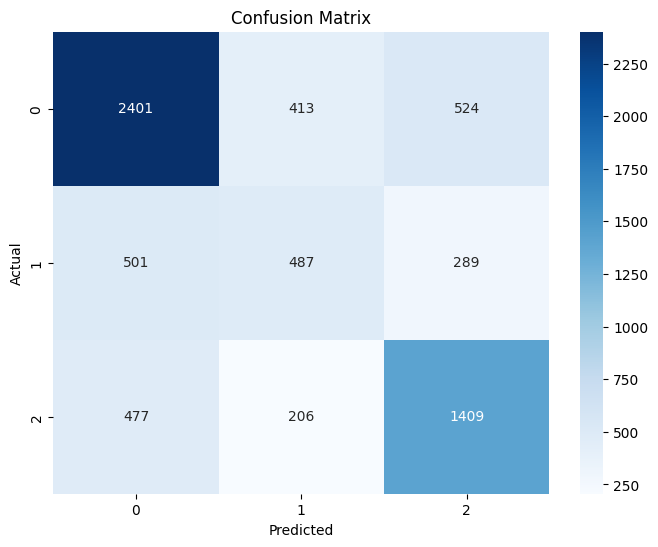

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()